# HOOKAH SPADING

Here's my attempt to summarize hookah impact from my personal activations. A few caveats: 
- I floored sugar rush & the general store potion effects to 2 activations, because both can come from items that increment in 3s and I suspect my lazy session parser couldn't differentiate hookah from just buying/using those items. that said, I am 90% sure hookah CAN generate those effects. 
- Also, some of the hookah activations I had ended up having strings that were not matchable with the mafia effects directory. 
- Also, any effect that isn't strictly one-number (IE, effects having to do with moonsign or fullness or turns of the effect remaining) were not tabulated because I didn't want to. 
- Also, I ignored the prismatic damage calculation because I also didn't want to.
- Also, I summed up mox/myst/mus into one stat for %stat and flat stat, because that felt reasonable-ish. 

In [60]:
import pandas as pd
import requests
import numpy as np
from collections import Counter

import seaborn as sb
from matplotlib import pyplot as plt

# Import modifiers from the most recent KOLMafia build. 
mafiaMODS = requests.get('https://svn.code.sf.net/p/kolmafia/code/src/data/modifiers.txt').text

In [61]:
import warnings
warnings.simplefilter('ignore')

In [62]:
import os

sessionDir   = '/Users/amcguire/Library/Application Support/KoLmafia/sessions'
    
# Extract & save all Hookah effects from my personal logs

hookah = []

for file in os.listdir(sessionDir):
    
    # I use a Mac, so I have to correct for my DS store hidden files
    if file != '.DS_Store':
        
        currFile = open('{}/{}'.format(sessionDir, file)).read()

        for ct, line in enumerate(currFile.split(sep='\n')):
            if line[0:22] == 'You acquire an effect:': # Always the starting string.
                if line[-3:] == '(6)': # Hookah activations always give 6 turns.
                    hookah = hookah + [line[23:-3].strip()] # Add it to the list!
                    
print('There have been {} hookah activations in your sessions.'.format(len(hookah)))

f = open(os.getcwd() + 'myEffects.csv','w+',newline='')
for h in hookah:
    f.write(str(h)+'\n')
f.close()

There have been 1610 hookah activations in your sessions.


In [63]:
# Extract and use Tiaan's provided data
file = open(os.getcwd() + '/tiaanEffects.txt',encoding = "ISO-8859-1").read()

for ct, line in enumerate(file.split(sep='\n')[1:]):
    hookah = hookah+[line[24:-4]]

print("Adding Tiaan's, there have now been {} hookah activations in all sessions.".format(len(hookah)))

Adding Tiaan's, there have now been 2706 hookah activations in all sessions.


# WAYS HOOKAH EFFECTS CAN ACTUALLY SAVE TURNS, CATEGORIZED
    1.  Generating Inigo's in a free fight so you have all 5 turns of it (1 turn)
    2.  The Stone Wool effect (depending on temple status can save a semirare or hunting for wool)
    3.  Meat drop effects when you're finishing nuns (anywhere from <1 to 2 turns @ maximum)
    4.  Item drop effects when you're short on capping something (<1 turn)
    5.  Init for modern zmobies (1-2 turns potentially)
    6.  Sleaze damage for the protestor mob (very rare, but possibly saves a wish?)
    7.  Prismatic damage for tavern (or just whatever you're missing @ tower, saves a turn maybe); NOT COVERED
    8.  Sleaze resist for blech house (rare and almost certainly 100% unnecessary)
    9.  Covetous Robbery making you extremely rich early in-run
    10. +Stat gain; flat or % effects
    11. Very, very high stat increases for scaling fights

In [64]:
def modParse(x):
    ''' Quick custom function w/ exception for parsing modifiers from plaintext '''
    try: 
        return int(x.split('+')[1])
    except:
        return 0

def parseEffects(eff):
    ''' Function to parse through effects and generate #s according to useful in-run
        applications of hookah/horsery effects, per those examined above. I am ignoring
        Prismatic damage out of laziness; if you want to add it, just do a long 
        any-type list comp like I did for the flat/pct stats. '''
    
    meatDrop  = 0
    itemDrop  = 0
    init      = 0
    sleazeDmg = 0
    sleaseRes = 0
    poolSkill = 0
    
    famWeight = 0
    
    flatXP    = 0
    pctXP     = 0
    
    flatstat  = 0
    pctstat   = 0
    
    for x in eff:
        
        if     'Initiative'            in x: init = init + modParse(x)
        elif   'Meat Drop'             in x: meatDrop = meatDrop + modParse(x)
        elif   'Item Drop'             in x: itemDrop = itemDrop + modParse(x)
        elif   'Sleaze Damage'         in x: sleazeDmg = sleazeDmg + modParse(x)
        elif   'Sleaze Spell Damage'   in x: sleazeDmg = sleazeDmg + modParse(x)
        elif   'Sleaze Resistance'     in x: sleaseRes = sleaseRes + modParse(x)
        elif   'Pool Skill'            in x: poolSkill = poolSkill + modParse(x)
            
        elif   'Familiar Weight'       in x: famWeight = famWeight + modParse(x)
        
        elif   'Experience Percent'    in x: pctXP = pctXP + modParse(x)
        elif   'Experience (Familiar)' in x: flatXP = flatXP + 0
        elif   'Experience'            in x: flatXP = flatXP + modParse(x)
        
        elif any(y in x for y in ['Moxie Percent','Mysticality Percent','Muscle Percent']): 
            pctstat = pctstat + modParse(x) 
        elif any(y in x for y in ['Moxie','Mysticality','Muscle']): 
            flatstat = flatstat + modParse(x)
    
    effDict = {'meat':meatDrop, 'item':itemDrop,'init':init, 'sleazeDmg':sleazeDmg, 
               'sleazeRes':sleaseRes, 'poolSkill':poolSkill, 'famWeight':famWeight,
               'flatXP':flatXP,'pctXP':pctXP,'flatStats':flatstat,'pctStat':pctstat}
    
    return effDict

# test it w/ wolf form, which should have 150 mus% and 150 meatdrop
# parseEffects(modsDF.loc[modsDF['NAME']=='Wolf Form',['EFFECTS']].values[0][0])

In [65]:
def parseRawMods(txt):
    ''' Parsing out what the effects actually do. Generates a dictionary. '''
    if txt == '': # Remove blank rows.
        return ''
    elif txt[0] == '#': # Remove comments.
        return ''
    elif txt == '3': # Remove the weird extraneous "3" that starts the file
        return ''
    elif '\tAvatar: ' in txt: # Remove avatar potions.
        return
    
    effType = txt.split('\t')[0]
    effName = txt.split('\t')[1]
    effects = txt.split('\t')[2].split(',')
    effDict = parseEffects(effects)
    
    return {'NAME':effName,'TYPE':effType,'EFFECTSLIST':effects, **effDict}
    
modsList = list(filter(None, [parseRawMods(x) for x in mafiaMODS.split('\n')]))
modsDF = pd.DataFrame(modsList)

In [66]:
# testing to make sure the effects are properly generating

for x in hookah[5:10]:
    print('{} gives the effects: {}'.format(x, modsDF.loc[modsDF['NAME']==x,'EFFECTSLIST'].values))

The Halls of Moxiousness gives the effects: [list(['Experience (Moxie): +3'])]
Always be Collecting gives the effects: [list(['Item Drop: +50', ' Meat Drop: +100'])]
The Wisdom... of the Future gives the effects: [list(['Mysticality Percent: +50', ' Mysticality: +15', ' Experience (Mysticality): +3'])]
Spiky Hair gives the effects: [list(['Muscle: +6', ' Moxie: +6'])]
Cruisin' for a Bruisin' gives the effects: [list(['Weapon Damage Percent: +100'])]


In [67]:
# Use an efficient counter function to figure out how many activations each respective skill had
countHookah = Counter(hookah)
modsDF['hookah'] = [countHookah[x] for x in modsDF.NAME]

# When sorting by activations, noticed that Sugar Rush & the general 
#   store effects were high up. This makes some sense, as those can 
#   be generated in multiples of 3. Will floor these to 2 on the 
#   assumption mafia is incorrectly categorizing them.

print(modsDF.loc[:,['NAME','hookah']].sort_values(by=['hookah'],ascending=False).head(5))

for effect in ['Sugar Rush', "Go Get 'Em, Tiger!", "Glittering Eyelashes", "Butt-Rock Hair"]:
    modsDF.loc[modsDF['NAME'] == effect,['hookah']] = 2

modsDF.loc[:,['NAME','hookah']].sort_values(by=['hookah'],ascending=False).head(10)

                            NAME  hookah
5167                  Sugar Rush      23
4251          Go Get 'Em, Tiger!      15
4245        Glittering Eyelashes      10
5409  Weapon of Mass Destruction       9
5076                 Space Cadet       8


,NAME,hookah
5409,Weapon of Mass Destruction,9
4304,Half-Eaten Brain,8
3669,Astral Shell,8
5076,Space Cadet,8
5439,Wintry Breath,7
3824,Bugbear in Tooth and Claw,7
4218,Fruited,7
4254,Going Ape,7
4282,Grrrrrrreat!,7
4816,Pisces Rising,7


In [68]:
# Looking at effects that do not appear to be hookah-activated, we see a 
#   lot of ML & "negative" effects; this fits our intuition. That said, 
#   there are a few here that are probably actually eligible.

modsDF.loc[(modsDF['hookah']==0) & (modsDF['TYPE'] == 'Effect'),['EFFECTSLIST','NAME']].head()

,EFFECTSLIST,NAME
3578,[Moxie: -5],&quot;The Disease&quot;
3580,"[Muscle: +6, Moxie: -3]",1337p4n7Z
3581,"[Experience: +3, Experience (familiar): +3]","2 Hearts, 1 Mind"
3587,"[Familiar Weight: +5, Experience (familiar): ...",A Girl Named Sue
3588,[Monster Level: +2],[597]A Little Bit Evil


In [69]:
# Effects that are useful in and of themselves:

usefulEffects = ['Stone-Faced',                                     # Useful to unlock the Hidden City
                 'Craft Tea', "Inigo's Incantation of Inspiration", # Free crafts!
                 "Covetous Robbery",                                # Gobs of extra meat
                 "Dirty Pear",                                      # Doubles sleaze damage; OP for Copperhead
                 "Got Milk", "Ode to Booze"                         # Extra adventures from food/booze
                ]

for eff in usefulEffects:
    print('{} occurred in {} of {} activations, a rate of {:.2%}.'.format(eff,countHookah[eff],len(hookah),countHookah[eff]/len(hookah)))

Stone-Faced occurred in 2 of 2706 activations, a rate of 0.07%.
Craft Tea occurred in 2 of 2706 activations, a rate of 0.07%.
Inigo's Incantation of Inspiration occurred in 3 of 2706 activations, a rate of 0.11%.
Covetous Robbery occurred in 2 of 2706 activations, a rate of 0.07%.
Dirty Pear occurred in 2 of 2706 activations, a rate of 0.07%.
Got Milk occurred in 2 of 2706 activations, a rate of 0.07%.
Ode to Booze occurred in 1 of 2706 activations, a rate of 0.04%.


In [70]:
def summarizeField(df, fName, c='g', lowBound=0):
    ''' Summarization function for individual fields. '''
    
    # Filter down to only effects w/ hookah activations & relevant column for summarization
    df = df.loc[df['hookah']>0,[fName,'hookah']]
    
    allActivations = sum(df['hookah'])
    
    # Cut out non-relevant activations now that we know the #
    df = df.loc[df[fName]>lowBound,:]
    
    print('For {}, there were {} relevant activations out of {}, a rate of {:.2%}.\n'.format(fName,sum(df['hookah']),allActivations,sum(df['hookah'])/allActivations))
    
    allAvg = sum(df[fName]*df['hookah'])/allActivations
    popAvg = sum(df[fName]*df['hookah'])/sum(df['hookah'])
    print('  Average per activation:    +{:0.5}'.format(allAvg))
    print('  Average when activated:    +{:0.5}\n'.format(popAvg))
    print('  Maximum buff:              +{}, {} times\n'.format(max(df[fName].values),sum(df.loc[df[fName]==max(df[fName]),['hookah']].values[0])))
    
    # Generate a nice histogram of the distribution of activation buffs assuming equal activations
    fig, ax = plt.subplots()
    sb.distplot(df[fName],kde = False, color=c,ax=ax)
    ax.set(ylabel="# of Activations") 
    sb.set_style("dark")
    sb.despine()
    plt.show()
    

For init, there were 168 relevant activations out of 2517, a rate of 6.67%.

  Average per activation:    +3.3186
  Average when activated:    +49.72

  Maximum buff:              +300, 1 times



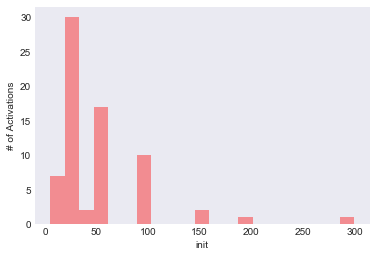

For meat, there were 129 relevant activations out of 2517, a rate of 5.13%.

  Average per activation:    +2.468
  Average when activated:    +48.155

  Maximum buff:              +200, 1 times



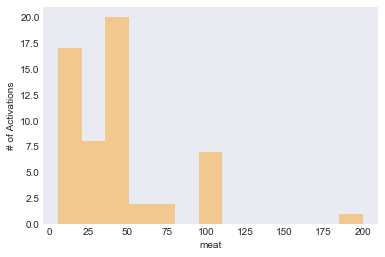

For item, there were 169 relevant activations out of 2517, a rate of 6.71%.

  Average per activation:    +1.7394
  Average when activated:    +25.905

  Maximum buff:              +100, 2 times



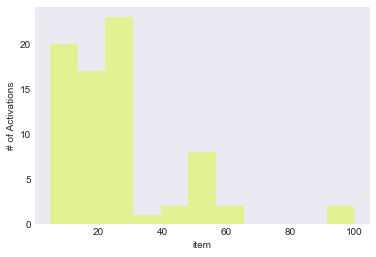

For sleazeDmg, there were 86 relevant activations out of 2517, a rate of 3.42%.

  Average per activation:    +0.87406
  Average when activated:    +25.581

  Maximum buff:              +100, 1 times



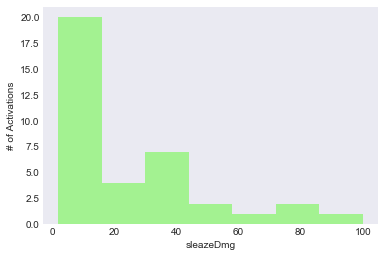

For sleazeRes, there were 65 relevant activations out of 2517, a rate of 2.58%.

  Average per activation:    +0.061979
  Average when activated:    +2.4

  Maximum buff:              +9, 2 times



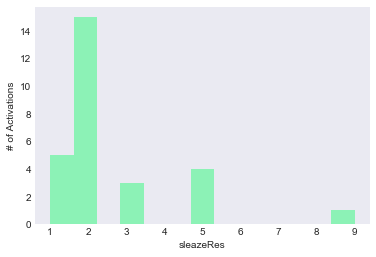

For poolSkill, there were 7 relevant activations out of 2517, a rate of 0.28%.

  Average per activation:    +0.0099325
  Average when activated:    +3.5714

  Maximum buff:              +5, 1 times



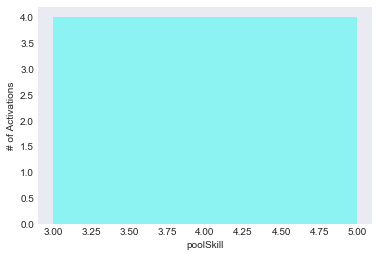

For famWeight, there were 92 relevant activations out of 2517, a rate of 3.66%.

  Average per activation:    +0.21891
  Average when activated:    +5.9891

  Maximum buff:              +10, 3 times



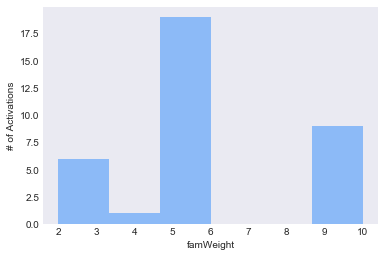

For flatXP, there were 166 relevant activations out of 2517, a rate of 6.60%.

  Average per activation:    +0.24474
  Average when activated:    +3.7108

  Maximum buff:              +12, 1 times



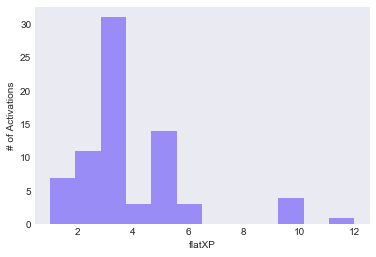

For pctXP, there were 24 relevant activations out of 2517, a rate of 0.95%.

  Average per activation:    +0.14104
  Average when activated:    +14.792

  Maximum buff:              +25, 1 times



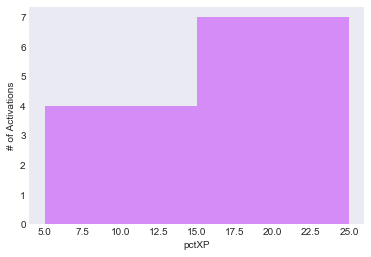

For flatStats, there were 324 relevant activations out of 2517, a rate of 12.87%.

  Average per activation:    +3.0795
  Average when activated:    +23.923

  Maximum buff:              +120, 2 times



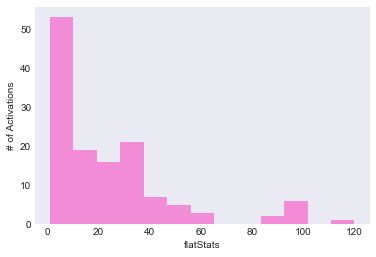

For pctStat, there were 444 relevant activations out of 2517, a rate of 17.64%.

  Average per activation:    +13.931
  Average when activated:    +78.973

  Maximum buff:              +600, 3 times



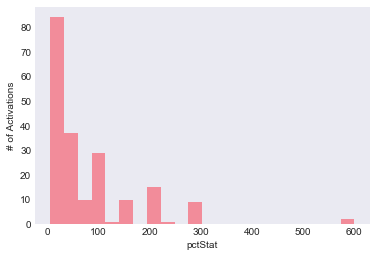

In [71]:
buffsAnalyzed = ['init','meat','item','sleazeDmg','sleazeRes','poolSkill',
                 'famWeight','flatXP','pctXP','flatStats','pctStat']

cmap = plt.cm.get_cmap('hsv',len(buffsAnalyzed))

for i, x in enumerate(buffsAnalyzed):
    summarizeField(modsDF, x, c=cmap(i))

In [72]:
# Parsing out buffs that appeared in my hookah logs but cannot be merged w/ the modifiers table

modBuffs = set(modsDF.loc[(modsDF['hookah']>0),'NAME'].tolist())

for x in set(set(hookah) - modBuffs):
    print('{} ({})'.format(x,countHookah[x]))

Slicked-Back Do (5)
Stickler for Promptness (2)
Temporary Amnesia (2)
Ode to Booze (1)
Vanity Rage (1)
Everything Looks Yellow (3)
Booing Radly (3)
Burning Tongue (1)
Eau de Tortue (4)
Sticky Hands (3)
Red-Shirted Escort (2)
Deep-Seated Rage (2)
Super Skill (2)
Hammertime (3)
Permanent Halloween (1)
Cotton Mouthed (3)
Boon of the War Snapper (1)
Don't Rest Ye, Bold Adventurer (1)
All Covered In Whatsit (4)
Fudge Headache (3)
Jingle Jangle Jingle (2)
Wolf's Bane (2)
Partially Ghosted (3)
Frosty the Hitman (2)
Little Mouse Skull Buddy (2)
Mathematically Precise (1)
Coal-Powered (4)
Robocamo (3)
Salty Mouth (1)
Coy to the Hurled (2)
Curse of the Black Pearl Onion (1)
Yes, Can Haz (3)
Jelly Combed (4)
Cookie Backup (1)
Chocolate Reign (5)
Pygmy Drinking Buddy (3)
Flimsy Shield of the Pastalord (4)
Angry Bone (1)
Biologically Shocked (1)
Psalm of Pointiness (2)
X-Ray Vision (1)
Smokin' (3)
Bone Homie (2)
Got Milk (2)
Bloody-minded (4)
Earthen Fist (3)
Hip to the Jive (3)
Ruthlessly Efficien